## Dask

Dask is a big data processing library used for:
1. Parallelizing the computation of the workflows consisting of NumPy, pandas, xarray and scikit-learn frameworks.
2. Scaling the workflows up or down depending upon the hardware that is being used.

Check out if your workflow needs dask: [Why Dask?](https://docs.dask.org/en/latest/why.html)

---

Dask is an optional dependency inside ArviZ which is still being **actively developed**. Currently, few functions belonging to **diagnostics** and **stats** module can utlize dask's capabilties. An additional functionality of disabling/re-enabling dask has also been included for the systems which have dask installed.

In [1]:
import arviz as az
import numpy as np
import timeit
import dask

from arviz.utils import conditional_jit, Dask
from dask.distributed import Client, progress
from dask.diagnostics import ResourceProfiler

from bokeh.resources import INLINE
import bokeh.io
bokeh.io.output_notebook(INLINE)

%reload_ext memory_profiler

Loading BokehJS ...

In [2]:
client = Client(threads_per_worker=4, n_workers=1, memory_limit="1.2GB")
client

Client Scheduler: tcp://127.0.0.1:35461 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 1.12 GiB


### Variance example from numba doc with larger input data

**Calculating variance with numba.**

In [3]:
@conditional_jit
def variance_jitted(data, ddof=0):
    a_a, b_b = 0, 0
    for i in data:
        a_a = a_a + i
        b_b = b_b + i * i
    var = b_b / (len(data)) - ((a_a / (len(data))) ** 2)
    var = var * (len(data) / (len(data) - ddof))
    return var

In [4]:
%time %memit data = np.random.randn(1000000000)

peak memory: 7882.01 MiB, increment: 7630.36 MiB
CPU times: user 25.4 s, sys: 1.01 s, total: 26.4 s
Wall time: 26 s


In [5]:
%time variance_jitted(data, ddof=1)

CPU times: user 1.67 s, sys: 15.9 ms, total: 1.69 s
Wall time: 1.69 s


1.0000404984479865

**Calculating variance using dask arrays:**
- Divides the array into multiple chunks.
- Objects that are created are lazy and are computed on-the-fly.
- Builds a task graph of the entire computation and parallelizes the execution. 

In [6]:
%memit data = dask.array.random.normal(size=(1000000000))
data

peak memory: 260.80 MiB, increment: -7628.73 MiB


dask.array<normal, shape=(1000000000,), dtype=float64, chunksize=(15625000,), chunktype=numpy.ndarray>

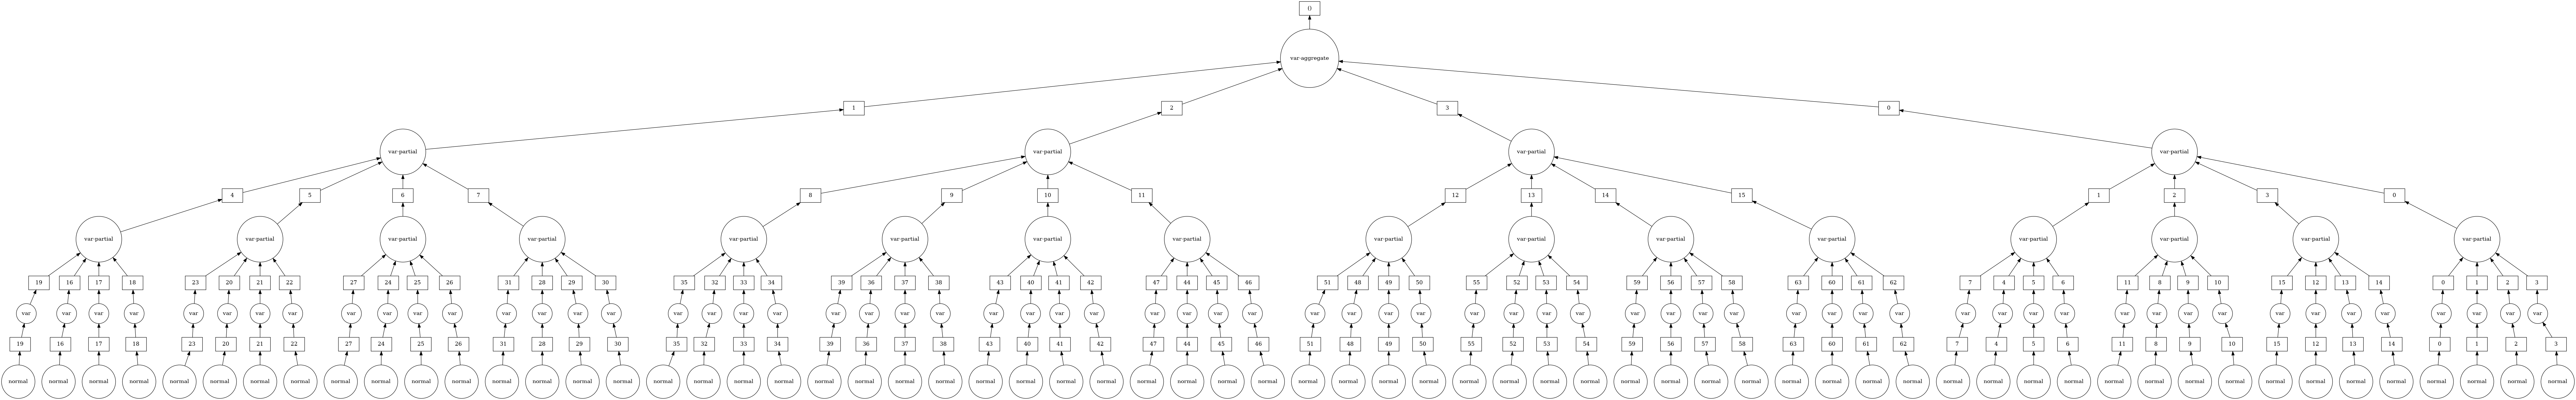

In [7]:
var = dask.array.var(data, ddof=1)
var.visualize()

In [8]:
with ResourceProfiler(dt=0.25) as rprof:
    var.compute()

In [9]:
rprof.visualize()

Figure(id='1003', ...)

_Here the numba version out performed dask because it's input data was already stored in-memory, but in the case of large datasets, storing everything inside main memory will lead to memory error and in such cases using dask can benefit your workflow._

**Note**: Setting up the right value of the chunks parameter is very important. Computation on Dask arrays with small chunks are slow because each operation on a chunk has some overhead. On the other side, if your chunks are too big, then it might not fit in the memory. 

### Lets take a look at some of the functions that supports dask.

_The first cell of each section runs the function without dask. Dask is enabled in the later cells._

**`arviz.ess`** 

In [10]:
%%time
%%memit

data = np.random.rand(10, 1000, 10000)
idata = az.from_dict(posterior={"var": data}, dims={"var": ["dim_1"]})
ess = az.ess(idata)

peak memory: 1025.98 MiB, increment: 763.85 MiB
CPU times: user 29.7 s, sys: 187 ms, total: 29.9 s
Wall time: 29.6 s


In [11]:
%%time
%%memit

Dask.enable_dask(dask_kwargs={"output_dtypes": [float]}) # enabling dask and global kwargs

data = dask.array.random.random((10, 1000, 10000), chunks=(10, 1000, 100))
idata = az.from_dict(posterior={"var": data}, dims={"var": ["dim_1"]})
ess = az.ess(idata, dask_kwargs={"dask": "parallelized"}) # we can also pass dask kwargs to the function itself

with ResourceProfiler(dt=0.25) as rprof:
    ess.compute()

peak memory: 1026.20 MiB, increment: 0.20 MiB
CPU times: user 1.03 s, sys: 107 ms, total: 1.13 s
Wall time: 21.8 s


In [12]:
rprof.visualize()
Dask.disable_dask()

Here, not only dask enabled method is faster, but it's also memory efficient compared to vanilla method.

We'll see more such examples below.

**`arviz.rhat`** 

In [13]:
%%time
%%memit

data = np.random.rand(10, 1000, 10000)
idata = az.from_dict(posterior={"var": data}, dims={"var": ["dim_1"]})
rhat = az.rhat(idata)

peak memory: 1028.71 MiB, increment: 763.16 MiB
CPU times: user 46.6 s, sys: 215 ms, total: 46.9 s
Wall time: 46.4 s


In [14]:
%%time
%%memit

Dask.enable_dask(dask_kwargs={"dask": "parallelized"})

data = dask.array.random.random((10, 1000, 10000), chunks=(10, 1000, 100))
idata = az.from_dict(posterior={"var": data}, dims={"var": ["dim_1"]})
rhat =  az.rhat(idata, dask_kwargs={"output_dtypes": [float]})

with ResourceProfiler(dt=0.25) as rprof:
    rhat.compute()

peak memory: 1028.75 MiB, increment: 0.04 MiB
CPU times: user 1.26 s, sys: 139 ms, total: 1.4 s
Wall time: 30.9 s


In [15]:
Dask.disable_dask()

**`arviz.hdi`** 

In [16]:
%%time
%%memit

data = np.random.normal(size=(10, 1000, 10000))
az.hdi(data, hdi_prob=.68)

peak memory: 1031.57 MiB, increment: 762.98 MiB
CPU times: user 9.72 s, sys: 122 ms, total: 9.84 s
Wall time: 9.79 s


In [17]:
%%time
%%memit

Dask.enable_dask(dask_kwargs={"dask": "parallelized", "output_dtypes": [float]})

data = dask.array.random.normal(size=(10, 1000, 10000), chunks=(10, 1000, 100))
idata = az.from_dict(posterior={"var": data}, dims={"var": ["dim_1"]})
hdi = az.hdi(idata, hdi_prob=0.68, dask_gufunc_kwargs={"output_sizes": {"hdi": 2}})

hdi.compute()

peak memory: 1031.57 MiB, increment: 0.00 MiB
CPU times: user 623 ms, sys: 53.8 ms, total: 677 ms
Wall time: 4.4 s


In all the examples, it's noticeable that:
1. Data structures provided by dask reduces the overall memory footprint, as it divides them into multiple chunks.
2. Due to the breakdown of complex computations into small tasks and parallelizing the executions, dask supported methods achieve significant performance gain.

In [18]:
Dask.disable_dask()
client.close()